In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import tensorflow as tf
import sklearn.metrics
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow import keras
import os
import plotly.express as px
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from keras.models import Model
from sklearn.preprocessing import StandardScaler
import datetime
from sklearn import datasets
import seaborn as sns

In [ ]:
!cp -r "/content/drive/MyDrive/Colab Notebooks/Needed2/buy_list_10%" "./buy"
!cp -r "/content/drive/MyDrive/Colab Notebooks/Needed2/sell_list_10%" "./sell"
!cp -r "/content/drive/MyDrive/Colab Notebooks/Needed2/Stock_K_Data" "./data_k"

In [ ]:
buy_files = os.listdir("./buy")
sell_files = os.listdir("./sell")
data_files = os.listdir("./data_k")
X_all_train = []
X_all_test = []
y_all_train = []
y_all_test = []

for f in buy_files:
    if ".csv" not in f: # not csv file
        continue
    data_date = pd.read_csv("./buy/" + f)
    data_k = pd.read_csv("./data_k/" + f)
    data_date.dropna(inplace=True)
    data_k.dropna(inplace=True)
    data_k.drop(columns=['close','after_inc_dec'],inplace=True)
    if len(data_date) == 0 or len(data_k) == 0:
      continue
    data_date.reset_index(drop=True, inplace=True)
    data_k.reset_index(drop=True, inplace=True)

    for i in range(len(data_date)):
        date_idx = data_date.iloc[i, 0]
        date_str = data_date.iloc[i, 0].split()[0]
        date = datetime.datetime.strptime(date_str, "%Y-%m-%d")
        try:
            idx = data_k.index[data_k.Date == date_idx][0]
        except:
            continue
        check_volume = data_k.iloc[idx, -2]
        if check_volume < 0.01:
            continue
        x = data_k.iloc[idx, 1:]
        y = 1
        if date.year >= 2010:
          if date.year < 2022:    # train
              X_all_train.append(x)
              y_all_train.append(y)
          elif date.year >= 2022 and date.year<=2023:  # validation
              X_all_test.append(x)
              y_all_test.append(y)

for f in sell_files:
    if ".csv" not in f: # not csv file
        continue
    data_date = pd.read_csv("./sell/" + f)
    data_k = pd.read_csv("./data_k/" + f)
    data_date.dropna(inplace=True)
    data_k.dropna(inplace=True)
    data_k.drop(columns=['close','after_inc_dec'],inplace=True)
    if len(data_date) == 0 or len(data_k) == 0:
      continue
    data_date.reset_index(drop=True, inplace=True)
    data_k.reset_index(drop=True, inplace=True)

    for i in range(len(data_date)):
        date_idx = data_date.iloc[i, 0]
        date_str = data_date.iloc[i, 0].split()[0]
        date = datetime.datetime.strptime(date_str, "%Y-%m-%d")
        try:
            idx = data_k.index[data_k.Date == date_idx][0]
        except:
            continue
        check_volume = data_k.iloc[idx, -2]
        if check_volume < 0.01:
            continue
        x = data_k.iloc[idx, 1:]
        y = 0

        if date.year>=2010:
          if date.year < 2022:    # train
              X_all_train.append(x)
              y_all_train.append(y)
          elif date.year >= 2022 and date.year<=2023:  # validation
              X_all_test.append(x)
              y_all_test.append(y)

print("train:")
for i in range(2):
    print(f"{i}: {y_all_train.count(i)}筆", end="\t")
print("\ntest:")
for i in range(2):
    print(f"{i}: {y_all_test.count(i)}筆", end="\t")
y_all_train = tf.keras.utils.to_categorical(y_all_train, num_classes=2)
y_all_test = tf.keras.utils.to_categorical(y_all_test, num_classes=2)
X_all_train = np.array(X_all_train)
X_all_test = np.array(X_all_test)
y_all_train = np.array(y_all_train)
y_all_test = np.array(y_all_test)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_all_train)
X_all_train = scaler.transform(X_all_train)
X_all_test = scaler.transform(X_all_test)

train:
0: 9490筆	1: 12379筆	
test:
0: 1580筆	1: 1709筆	

把順序打亂

In [ ]:
import random
seed=3
torch.manual_seed(seed)  # 設定 PyTorch 的隨機種子
np.random.seed(seed)
a = [None] * len(X_all_train)
b = random.sample([i for i in range(len(X_all_train))],len(X_all_train))


X_all_train = X_all_train[b]
y_all_train = y_all_train[b]

y_all_train = np.argmax(y_all_train,axis=1)

In [ ]:
!pip install torch # install the torch module

import torch # import the torch module
# seed=2
# torch.manual_seed(seed)  # 設定 PyTorch 的隨機種子
# np.random.seed(seed)

In [ ]:
from sklearn.svm import SVC
from sklearn import svm
from sklearn.metrics import mean_squared_error, matthews_corrcoef
import time

# 建立 kernel='rbf' 模型
rbfModel=svm.SVC(kernel='rbf', gamma=1, C=1, probability=True)

# 使用訓練資料訓練模型`
start = time.time()
rbfModel.fit(X_all_train, y_all_train)
end = time.time()
print(f"Training time: {end - start}s")

y_pred_test = rbfModel.predict(X_all_test)

# 評估
y_pred_test_labels = y_pred_test

# 計算MCC
mcc_test = matthews_corrcoef(np.argmax(y_all_test,1), y_pred_test_labels)

# 計算準確率

accuracy = rbfModel.score(X_all_test, np.argmax(y_all_test,1))

Training time: 371.70728874206543s


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_true = np.argmax(y_all_test,1)
y_pred = y_pred_test
accuracy = accuracy_score(y_true, y_pred)

#計算精確度
precision = precision_score(y_true, y_pred)

#計算召回率
recall = recall_score(y_true, y_pred)

#計算F1-score
f1 = f1_score(y_true, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")
print(f"MCC: {mcc_test}")

Accuracy: 0.5396777135907571
Precision: 0.5371995421594811
Recall: 0.8238736102984201
F1-score: 0.6503464203233256
MCC: 0.06973387015540089


畫ROC圖+混淆矩陣

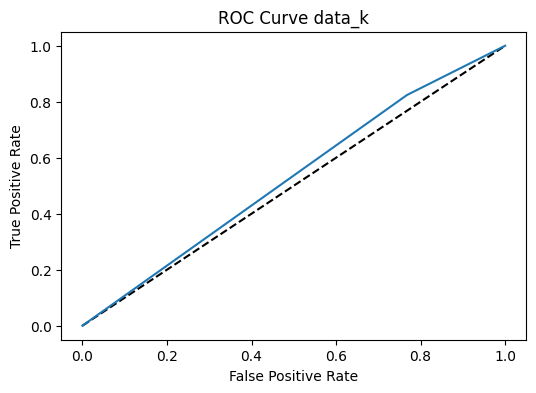

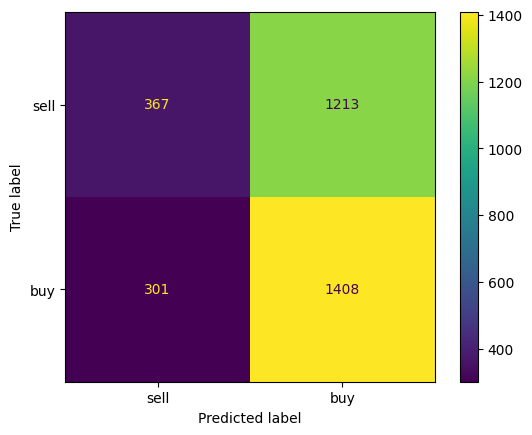

In [ ]:
from sklearn.metrics import roc_curve
def draw_roc_curve(y_true, y_pred):
  # Calculate the ROC curve
  fpr, tpr, thresholds = roc_curve(y_true, y_pred)

  # Plot the ROC curve
  fig = plt.figure(figsize=(6, 4))
  plt.plot([0, 1], [0, 1], 'k--')  # Plot the diagonal 50% line
  plt.plot(fpr, tpr)  # Plot the FPR and TPR achieved by the model
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC Curve data_k')
  plt.show()

# Get the predictions
y_pred = rbfModel.predict(X_all_test)

# Convert the true labels to class labels
y_true_class = np.argmax(y_all_test, axis=1)

# Draw the ROC curve
draw_roc_curve(y_true_class, y_pred)


# 預測

for i in range(len(y_pred)):
  if y_pred[i] >= 0.5:
    y_pred[i] = 1
  else:
    y_pred[i] = 0

import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(y_true_class, y_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["sell", "buy"])

cm_display.plot()
plt.show()

尋找閥值


In [ ]:
tmp = rbfModel.predict_proba(X_all_test)

t_0=[]
t_1=[]

for i in range(len(tmp)):
  t_0.append(tmp[i][0])
  t_1.append(tmp[i][1])

sorted_tmp_0 = sorted(t_0)
sorted_tmp_1 = sorted(t_1)
t0 = int(len(sorted_tmp_0) * 0.99)
t1 = int(len(sorted_tmp_1) * 0.99)

threshold0 = sorted_tmp_0[t0]
threshold1 = sorted_tmp_1[t1]

print("sell 閥值: ",threshold0)
print("buy 閥值: ",threshold1)

sell 閥值:  0.585402775549326
buy 閥值:  0.6787128983824215


切出test資料

In [ ]:
!rm -rf "raw_data"
!mkdir "raw_data"
test_dir = os.listdir('/content/drive/MyDrive/Colab Notebooks/Needed2/StockData')

for i in test_dir:
  new_d = []
  if ".csv" not in i:
    continue
  d = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Needed2/StockData/" + i)
  # print(f"====={i}=====")
  d.dropna(inplace=True)
  # d.drop(columns=['close','after_inc_dec'],inplace=True)
  d.reset_index(drop=True,inplace=True)

  for j in range(len(d)):
    date_str = d.iloc[j, 0].split()[0]
    date = datetime.datetime.strptime(date_str, "%Y-%m-%d")

    if date.year == 2024:
      new_d.append(d.iloc[j, ])
  new_data = pd.DataFrame(new_d)
  new_data.to_csv("/content/raw_data/" + i, index=False)

In [ ]:
!rm -rf "test_data"
!mkdir "test_data"

test_dir = os.listdir('/content/drive/MyDrive/Colab Notebooks/Needed2/Stock_K_Data')

for i in test_dir:
  new_d = []
  if ".csv" not in i:
    continue
  d = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Needed2/Stock_K_Data/" + i)
  # print(f"====={i}=====")
  d.dropna(inplace=True)
  d.drop(columns=['close','after_inc_dec'],inplace=True)
  d.reset_index(drop=True,inplace=True)

  for j in range(len(d)):
    date_str = d.iloc[j, 0].split()[0]
    date = datetime.datetime.strptime(date_str, "%Y-%m-%d")

    if date.year == 2024 and date.month < 8:
      new_d.append(d.iloc[j, ])
    if date.year == 2024 and date.month == 8 and date.date == 1:
      new_d.append(d.iloc[j, ])
  new_data = pd.DataFrame(new_d)
  new_data.to_csv("/content/test_data/" + i, index=False)

buy/sell list 隔天大漲大跌的probabilty(8%以上)

In [ ]:
for i in range(1):
  data = pd.read_csv("/content/rise.csv")
  data.drop(columns=['Date'], inplace=True)
  scaler = StandardScaler().fit(data)
  x = []
  for j in range(len(data)):
    x.append(data.iloc[j])

  x = np.array(x)
  x = scaler.transform(x)
  result = rbfModel.predict_proba(x)
  print(result)

[[0.43391116 0.56608884]
 [0.42559223 0.57440777]]


丟模型跑出預測結果

In [ ]:
!rm -rf "signal"
!mkdir "signal"
test_dir = os.listdir('/content/test_data')
sell_count=0
buy_count=0
count=0
df=pd.DataFrame()
for i in test_dir:
  if ".csv" not in i:
    continue
  data = pd.read_csv("/content/test_data/" + i)
  count+=1
  # print(f"====={i}=====")
  # data.dropna(inplace=True)
  if len(data) == 0:
    continue
  date = data['Date']
  data.drop(columns=['Date'], inplace=True)
  scaler = StandardScaler().fit(data)
  x = []
  for j in range(len(data)):
    x.append(data.iloc[j])

  x = np.array(x)
  x = scaler.transform(x)

  result = rbfModel.predict_proba(x)
  sell_buy = []
  for j in result:
    if j[0] >= threshold0:
      sell_count+=1
      sell_buy.append(0)
    elif j[1]>= threshold1:
      buy_count+=1
      sell_buy.append(1)
    else:
      sell_buy.append(-1)

  data['Date'] = date
  data["result"] = sell_buy
  data["sell"] = result[:, 0]
  data["buy"] = result[:, 1]

  data.to_csv("/content/signal/" + i, index=False)
print("sell: ",sell_count)
print("buy: ",buy_count)

sell:  22
buy:  14


計算profits

In [ ]:
from __future__ import print_function
stock = os.listdir("/content/signal/") #有buy sell 訊號的檔案
col_name3=['Date','result','W/L']

n = 0
total_count_W = 0
total_count_L = 0
total_count = 0
total_profits = 0
count_p = 0
count_n = 0
for i in stock:
  profit = 0
  count_W = 0
  count_L = 0
  count_0 = 0
  count_1 = 0
  count_null = 0
  data_analyise=[]
  if ".csv" not in i: # not csv file
    continue

  data_result = pd.read_csv("/content/signal/" + i) #日期跟操作
  data_k = pd.read_csv("/content/raw_data/" + i) #只有日期高低收

  for j in range(len(data_result)):  #在結果資料中找到，對應的日期和操作
    flag=0 #紀錄是否已經加入過新的list
    target_date = data_result.loc[j,'Date']
    target_oper = data_result.loc[j,'result']

    for k in range(len(data_k)-1):
      if flag == 1:
        break;

      if data_k.loc[k,'Date'] == target_date and target_oper != -1:
        present = data_k.loc[k,'Close']
        for t in range(k+1,k+11):
          if t == k+10 or t == len(data_k)-1:
            count_null+=1
            data_analyise.append((data_result.loc[j,'Date'], data_result.loc[j,'result'], ((data_k.loc[t,'Close']-data_k.loc[k,'Close'])/data_k.loc[k,'Close'])))
            if target_oper == 1:
              profit+=((data_k.loc[t,'Close']-data_k.loc[k,'Close'])/data_k.loc[k,'Close'])
              flag=1
              break;
            elif target_oper == 0:
              profit-=((data_k.loc[t,'Close']-data_k.loc[k,'Close'])/data_k.loc[k,'Close'])
              flag=1
              break;

          future_high = data_k.loc[t,'High'] #找出最高最低點，做止損止盈
          future_low = data_k.loc[t,'Low']
          percent_low = (future_low-present)/present
          percent_high = (future_high-present)/present
          if target_oper == 0: #sell
            if percent_high >= 0.05: #sl
              profit-=percent_high
              data_analyise.append((data_result.loc[j,'Date'],data_result.loc[j,'result'],'L'))
              count_L+=1
              count_0+=1
              flag=1
              break;
            elif percent_low <= -0.1: #tp
              profit-=percent_low
              data_analyise.append((data_result.loc[j,'Date'],data_result.loc[j,'result'],'W'))
              count_W+=1
              count_0+=1
              flag=1
              break;
            else:
              continue

          elif target_oper == 1: #buy
            if percent_high >= 0.1: #tp
              profit+=percent_high
              data_analyise.append((data_result.loc[j,'Date'],data_result.loc[j,'result'],'W'))
              count_W+=1
              count_1+=1
              flag=1
              break;

            elif percent_low <= -0.05: #sl
              profit+=percent_low
              data_analyise.append((data_result.loc[j,'Date'],data_result.loc[j,'result'],'L'))
              count_L+=1
              count_1+=1
              flag=1
              break;
            else:
              continue

  print(f"====={i}=====")
  # print("sell: ",count_0)
  # print("buy: ",count_1)
  print("W: ",count_W)
  print("L: ",count_L)
  total_count += count_0 + count_1 + count_null
  if count_W + count_L == 0:
    print("win_rate: 0%")
  else:
    print("win_rate: {0:.2f}%".format(count_W / (count_W + count_L)*100))
  total_count_L+=count_L
  total_count_W+=count_W
  print("profits: {0:.2f}%".format(profit*100))
  total_profits+=profit
  if profit > 0:
    count_p+=1
  elif profit < 0:
    count_n+=1
  print("10天沒方向: ",count_null)
  df = pd.DataFrame(data_analyise)
  if df.empty: #如果這檔完全沒有任何信號則跳過
    continue
  df.columns = col_name3
  # df.to_csv("./output/" + i ,index=False)
  print("==========")

=====2886.TW.csv=====
W:  0
L:  0
win_rate: 0%
profits: 2.15%
10天沒方向:  1
=====1101.TW.csv=====
W:  0
L:  0
win_rate: 0%
profits: 3.44%
10天沒方向:  1
=====1303.TW.csv=====
W:  0
L:  0
win_rate: 0%
profits: 0.00%
10天沒方向:  0
=====2002.TW.csv=====
W:  0
L:  0
win_rate: 0%
profits: -4.89%
10天沒方向:  1
=====1301.TW.csv=====
W:  0
L:  0
win_rate: 0%
profits: -1.90%
10天沒方向:  1
=====2603.TW.csv=====
W:  0
L:  1
win_rate: 0.00%
profits: -5.37%
10天沒方向:  0
=====4904.TW.csv=====
W:  0
L:  0
win_rate: 0%
profits: 1.38%
10天沒方向:  1
=====3037.TW.csv=====
W:  0
L:  1
win_rate: 0.00%
profits: -5.57%
10天沒方向:  0
=====2379.TW.csv=====
W:  0
L:  0
win_rate: 0%
profits: 0.00%
10天沒方向:  0
=====6669.TW.csv=====
W:  0
L:  0
win_rate: 0%
profits: 0.00%
10天沒方向:  0
=====2330.TW.csv=====
W:  0
L:  0
win_rate: 0%
profits: 0.00%
10天沒方向:  0
=====2891.TW.csv=====
W:  0
L:  0
win_rate: 0%
profits: 5.13%
10天沒方向:  1
=====2881.TW.csv=====
W:  0
L:  0
win_rate: 0%
profits: 1.19%
10天沒方向:  2
=====2880.TW.csv=====
W:  0
L:  0
win_rat

In [ ]:
print("total profits: {0:.2f}%".format(total_profits*100))
print("win_rate: {0:.2f}%".format(total_count_W / (total_count_W + total_count_L)*100))
print("扣除手續費的獲利: {0:.2f}%".format(total_profits*100-total_count*0.6))
print("交易次數:  ",total_count)
print("P: ",count_p)
print("N: ",count_n)

total profits: -3.42%
win_rate: 28.57%
扣除手續費的獲利: -25.02%
交易次數:   36
P:  14
N:  11
